# On Random Number Generation

<span style="font-size: 12px; color: #777; float: right;">This cell contains Latex macros.</span>
$$
\newcommand{\ket}[1]{| #1 \rangle}
\newcommand{\bra}[1]{\langle #1 |}
$$

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/CQTech-womanium-hackathon/Random-number-generation-using-boson-sampling---ORCA-Computing/blob/main/challenge/demo.ipynb)

This is `Constantine Quantum Technologies`'s solution to ORCA Computing's challenge `Random number generation using boson sampling`.

### Team

- Abdellah Tounsi
- Amina Sadik
- Mohamed Messaoud Louamri
- Nacer eddine Belaloui
- Wafa Makhlouf
- Zakaria Benhaddouche

### Content:
* [Why do we need RNG?](#Why-do-we-need-RNG?)
    * [Science](#Science)
    * [Security](#Security)
* [The problem at hand](#The-problem-at-hand)
* [Making an RNG device](#Making-an-RNG-device)
    * [The (quantum) entropy source(s)](#The-(quantum)-entropy-source(s))
        * [Quantum RNG: Qubits](#Quantum-RNG:-Qubits)
        * [Quantum RNG: Boson Sampling](#Quantum-RNG:-Boson-Sampling)
    * [The post-processing](#The-post-processing)
        * [The Von Neumann post processing steps](#The-Von-Neumann-post-processing-steps:)
        * [The theory behind the Von Neumann post processing: independent elements](#The-theory-behind-the-Von-Neumann-post-processing:-independent-elements)
        * [the Von Neumann Post processing: dependent elements](#the-Von-Neumann-Post-processing:-dependent-elements)
        * [Post-processing: dependent elements, the unbiased way](#Post-processing:-dependent-elements,-the-unbiased-way)
* [Testing the randomness](#Testing-the-randomness)
* [The CQT RNG package](#The-CQT-RNG-package)
    * [Qubits-based Simulator](#Qubits-based-Simulator)
    * [Shi et al. Simulator(s)](#Shi-et-al.-Simulator(s))
    * [Real Devices: IBMQ](#Real-Devices:-IBMQ)
    * [Real Devices: Borealis](#Real-Devices:-Borealis)
* [Conclusion](#Conclusion)
* [References](#References)

### Installation

To download and install our package, uncomment and run the following command:

In [1]:
# !pip install cqt_rng

To download and import all the necessary scripts and packages. Run the following cells:

In [163]:
import requests
import glob
import os

In [164]:
import numpy as np
import matplotlib.pyplot as plt

In [165]:
if not os.path.isdir("./scripts/"):
    os.mkdir("./scripts/")

In [4]:
available_scripts = glob.glob("scripts/*")
required_scripts = ["metrics.py", "constants.py", "study_boson_sampler.py"]
scripts_url = "https://raw.githubusercontent.com/CQTech-womanium-hackathon/Random-number-generation-using-boson-sampling---ORCA-Computing/main/challenge/scripts/"

for rs in required_scripts:
    if os.path.join("scripts", rs) not in available_scripts:
        print("Downloading the script:", rs)
        s = requests.get(scripts_url + rs)
        open(os.path.join("scripts", rs), "wb").write(s.content)

In [5]:
%run scripts/study_boson_sampler.py

In [6]:
%run scripts/constants.py

In [7]:
%run scripts/metrics.py

## Why do we need RNG?

### Science

When, we think about science we think about it being deterministic and systematic both in the results and the methods. It might look strange that randomness has anything to do with science. Yet, there exist a whole class of [randomized algorithms](https://en.wikipedia.org/wiki/Randomized_algorithm) used in the scientic realm which are based on randomness. The most populars of these algorithms are called the [Monte Carlo algorithms](https://en.wikipedia.org/wiki/Monte_Carlo_algorithm). An example of such an algorithm used to determine the value of π (which is 3.1415..., in case you forgot 😄) is shown below:

The algorithm is as follows:
1. We throw random "darts" on a 1x1 square.
1. We calculate the number of "darts" that hit the interior of a circle whose center is the point (0.5, 0.5) and whose radius is 0.5.
1. The estimated value of π would be: 4 * Number of darts inside the circle / Total number of darts thrown.

An animation of the process is given below, in the beginning we will send darts one by one (so that you can visualize the steps) and after 50 darts we will send rounds of 1000 darts (so that we can reach a higher number of darts thrown).  

<img src="https://s4.gifyu.com/images/montecarlo_pi_good.gif" style="height: 300px" />

As you can see, we are converging towards the known value of π, how is this possible? Let's try to understand it.

The area of the circle is  $0.5^2 \pi$, and the area of the square is $1$. If we send darts uniformly (which is what we are doing). The probability that a dart ends inside the circle is $P =\text{Area of the circle} / \text{Area of the square} = 0.5^2 \pi/1 = \pi/4$. We can approximate this probability by sending a very large number of darts on the square $P \approx \text{Number of darts inside the circle}/\text{Total number of darts}$ and then we would find that: 

$$\pi = 4 P \approx 4  \frac{\text{Number of darts inside the circle}}{\text{Total number of darts}}$$

Let's see what we would get if there was biasness in the darts we threw (ie: the probability that a darts ends in a certain area is higher than the probability that it ends in another area):

<img src="https://s4.gifyu.com/images/montecarlo_pi_bad.gif" style="height: 300px"/>

As you can see from this animation, the darts are not uniformly thrown (they are sent closer to the center of the square). The value of π that we get is wrong 3.46 instead of 3.14.

We just saw how biasness in random numbers could lead to wrong results. Obviously, this is just a trivial example. Now, imagine that we had to use such an randomized algorithm to develop a drug for example. A small bias in the random numbers would lead to wrong results which would lead to dramatic results. This shows how important it is to generate **unbiased** random numbers.

If you want to know more on the impact of RNGs on scientific results, we recommend reading these 2 papers:

1. [Quality of random number generators significantly affects results of Monte Carlo simulations for organic and biological systems](https://pubmed.ncbi.nlm.nih.gov/20734313/)
1. [Random numbers for simulation](https://dl.acm.org/doi/10.1145/84537.84555)

### Security

Another critical application of random numbers generators is in cryptography. As we know, sensitive data should be stored and sent encrypted so that if it is intercepted by a malicious person. It would be impossible (or at least hard and tedious) to utilize it.

To encrypt a sensitive data, we need an [algorithm](https://en.wikipedia.org/wiki/Symmetric-key_algorithm) and a key. The key should be chosen by a random number generator.

Obviously, the best-case scenario is that the malicious person doesn't know the algorithm, the encrypted data, the key length, the key value or any information about the key. But, to maximize security, the encrypted data should still be "safe" even if the the algorithm, the  encrypted data, the key-length, and some information about the key is leaked.

What we mean by "safe" here is that it would take a very long time (up to multiple centuries) for a malicious person to crack the encryption using [Brute-force attack](https://en.wikipedia.org/wiki/Brute-force_attack). Beside the algorithm, the key is the second most important factor that influences the safety of our data. Obviously, a longer key would be a safer one but is there other factors that influence whether a key is less safe than another?

#### Entropy

Let's assume someone (who we will call Bob) captured an encrypted message that you sent. Bob knows which algorithm that you used to encrypt the message, he also knows the length of the key. Let's also assume that he knows the proportions of 0s and 1s in the key but Bob doesn't know the key itself. 

To crack your message, he decided to use a bruteforce method (i.e: test every single possible key which matches the proportions which he is aware of). Finally, let's assume that to bruteforce the message. He uses a computer which can test one key every hour.


##### Example 1:
For the sake of simplicity, let's consider that the key has 4 bits and that its made of 1 0-bits and 3 1-bits.
What are all the possible keys that Bob needs to test to crack the message? How many keys made of 4 bits have 1 zero and 3 ones? Let's count:

```
0111
1011
1101
1110
```

There are four possibilities. So, it would take up to 4 hours for bob to crack your encrypted message.

What if the keys was made of 2 0-bits and 2 1-bits?

Let's count:

```
0011
0101
0110
1001
1010
1100
```

There are four possibilities. So, it would take up to 6 hours for bob to crack your encrypted message.

It appears that the second-key (2 0-bits and 2 1-bits) is "safer".

##### Example 2:
Let's consider that the key has 16 bits. And see what proportion of bits leads to a higher number of keys $N$.

Instead of counting the possible keys manually, their exist a general method to find the number of keys $N$ of length $n$ with $r$ zeros is to use the formula (more details can be found in any [combinatorics](https://en.wikipedia.org/wiki/Combinatorics) course):

$$N = nCr = \frac{n!}{r! (n - r)!}$$ 

_This function is available in python's [scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.comb.html)._

In [8]:
from scipy.special import comb

for i in range(0, 17):
    print(f"The number of keys of length {16} with {i:2d}-zeros and {16-i:2d}-ones is: {int(comb(16, i)):5d}")

The number of keys of length 16 with  0-zeros and 16-ones is:     1
The number of keys of length 16 with  1-zeros and 15-ones is:    16
The number of keys of length 16 with  2-zeros and 14-ones is:   120
The number of keys of length 16 with  3-zeros and 13-ones is:   560
The number of keys of length 16 with  4-zeros and 12-ones is:  1820
The number of keys of length 16 with  5-zeros and 11-ones is:  4368
The number of keys of length 16 with  6-zeros and 10-ones is:  8008
The number of keys of length 16 with  7-zeros and  9-ones is: 11440
The number of keys of length 16 with  8-zeros and  8-ones is: 12870
The number of keys of length 16 with  9-zeros and  7-ones is: 11440
The number of keys of length 16 with 10-zeros and  6-ones is:  8008
The number of keys of length 16 with 11-zeros and  5-ones is:  4368
The number of keys of length 16 with 12-zeros and  4-ones is:  1820
The number of keys of length 16 with 13-zeros and  3-ones is:   560
The number of keys of length 16 with 14-zeros an

As you can see, the number of possible keys is at his highest when the proportion of 0s and 1s is of 50%. And this is a general result no matter the length of the key $n$, the number of possible keys is at its highest whenever the proportion is of 50%. In physics, we call these "more numerous possibilities": states of higher entropy. We implemented a method to calculate the entropy:

In [9]:
for i in range(0, 17):
    arr = np.append(np.full(i, 0), np.full(16 - i, 1))
    entrp = calculate_entropy(arr, type = "bits")
    print(f"The entropy of the keys of length {len(arr)} with {i:2d}-zeros and {16-i:2d}-ones is: {entrp:.3f}")

The entropy of the keys of length 16 with  0-zeros and 16-ones is: 0.000
The entropy of the keys of length 16 with  1-zeros and 15-ones is: 0.337
The entropy of the keys of length 16 with  2-zeros and 14-ones is: 0.544
The entropy of the keys of length 16 with  3-zeros and 13-ones is: 0.696
The entropy of the keys of length 16 with  4-zeros and 12-ones is: 0.811
The entropy of the keys of length 16 with  5-zeros and 11-ones is: 0.896
The entropy of the keys of length 16 with  6-zeros and 10-ones is: 0.954
The entropy of the keys of length 16 with  7-zeros and  9-ones is: 0.989
The entropy of the keys of length 16 with  8-zeros and  8-ones is: 1.000
The entropy of the keys of length 16 with  9-zeros and  7-ones is: 0.989
The entropy of the keys of length 16 with 10-zeros and  6-ones is: 0.954
The entropy of the keys of length 16 with 11-zeros and  5-ones is: 0.896
The entropy of the keys of length 16 with 12-zeros and  4-ones is: 0.811
The entropy of the keys of length 16 with 13-zeros 

As you can see states with higher entropy have a more uniform distribution of bits. **BUT ARE NOT** necessarily more random, the bitstring 0000000011111111 has entropy 1 and the bitstring 1011110101011 has ~0.5. Despite the fact that the second looks more random than the first. We will see other tests to measure randomness [below](#Testing-the-randomness).

We just demonstrated that if a malicious person intercepted our encrypted data and that he knew some information about the key (like the length and the distribution of bits). It would be harder for him to crack the encryption if the key has higher entropy (the 0, 1 bits are more uniformly distributed).

**Note**: The point made above was made for the sake of illustration, a highly biased key might be safer because an attacker would expected the key to have a uniform distribution and thus would waste time looking at brute-forcing more uniformly distributed keys. The final choice of the key and its distribution is up to ___ to choose. We will just emphasizes that given a uniform distributed bitstring, a key with any distribution can be built. So, the most important aspect of the RNGs is to give truly uniform and unreproducible bitstrings.

## The problem at hand

We saw how important it is to generate random numbers. Our task is to find a procedure that generates **uniform, unbiased, unreproducible random numbers with a sufficient rate**.

The problem might look simple. If you used `python`, you probably know that we have whole packages (`random`, `np.random`, ...) to generate random numbers. Let's take a look at `numpy`random number generator:

#### Pseudo-RNG

Let's see how to generate a random bitstring in python.

In [10]:
np.random.randint(0, 2, size = 10)

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 1])

That was easy as "py". But, how random are these numbers? The output above looks pretty random, so did we solve our problem already? Was it so trivial? No, `numpy` (and other prng) generate numbers which are **approximately random** using arithmetical methods. These numbers might be useful in a variety of applications but not in **critical applications** like security and science.

Let's try to understand how `numpy` generate its random numbers. For this, let's pick an [oversimplified algorithm](https://en.wikipedia.org/wiki/Pseudorandom_number_generator#Implementation).

In [11]:
def prng(seed, size):
    bitstring = np.empty(size, dtype=int)
    a, b = 17, 19 # a and b need to be prime numbers
    
    for i in range(size):
        num = seed * a
        bitstring[i] = np.round((num**3 % b) / b)
        seed += 1
        
    return bitstring

And generate a bitstring of length 95:

In [12]:
prng(42, 19 * 5)

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1])

This looks pretty random doesn't it? However, it is **not**:

1. Everyone who knows your algorithm and knows the initial state (the seed) would be able to **reproduce** your results.

In [13]:
prng(42, 19 * 5) # same output

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1])

2. If you look closely you will see that their is a pattern that get's repeated:

In [14]:
np.reshape(_, (5, 19))

array([[0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]])

You can check that the same happens with numpy, let's pick the seed to be `12` and run `np.random.randint`. On my PC, I get: `array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0])`. Try it on your PC, you would get the same results. This means that if their is a breach which would allow someone to know your `seed`. That person can easily reproduce all the random numbers you generate.

In [15]:
np.random.seed(12)
np.random.randint(0, 2, size = 10)

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0])

Of course, there exists more advanced algorithm's to generate random numbers but generating **truly random** numbers using a classical computer or a classical system is impossible. This means that we need to change paradigm. We should use a **Quantum** computer to solve our problem. 

Indeed, a key property of quantum system is the **randomness of the measurements** as long as the quantum state isn't in an eigenstate of the measured observable. 

> In quantum mechanics, a (quantum) system is said to be in a particular quantum state. For example, an electron can be in a spin up state ⬆️, we would write $\ket{Electron State} = \ket{⬆️}$. If we measure it, we will **with certainty** find its spin to be up. In this case, we say that the electron is in an eigenstate of the observable $S_z$. The electron could also be in a **superposition** of spin up ⬆️ and spin down ⬇️, we would write $\ket{Electron State} = \alpha\ket{⬆️} + \beta\ket{⬇️}$. In this case, the electron is not in an eigestate of the obserbable $S_z$ and a measurement has probability $|\alpha|^2$ to yield spin up ⬆️ and $|\beta|^2$ to yield spin down ⬇️.

So, to make a **truly random and unreproducible** entropy source. We should:
1. Pick a quantum system. 
1. Make sure that the system's state is an superposition.
1. Carry a measurement.
1. And we would obtain **truly random** and **unreproducible** results.

Let's see two examples of quantum systems which can be used:

## Making an RNG device

We can decompose the process of generating random numbers into two part:
1. **Entropy source**: The entropy source generates a sample of random numbers. The sample doesn't need to be uniform, we just expect it to be **truly random** and **unreproducible**.
1. **The post-processor**: The post-processor takes a sample of random numbers and outputs a bitstring which should be **uniform**.

Applying the post-processor on the samples taken from entropy source should guarantee that our final output is: **truly random, unreproducible and uniform**.

### The (quantum) entropy source(s)

#### Quantum RNG: Qubits

A qubit is any two-states (state $\ket{0}$ and state $\ket{1}$) quantum system. We can apply a superposing gate on a $\ket{0}$-state qubit (for example: the hadamard $H$ or the rotation on y-axis $R_y(\theta)$). To obtain, a quantum state:

$$\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$$

Then, after making a measurement, we would obtain $0$ with probability $|\alpha|^2$ and $1$ with probability $|\beta|^2$.

This is a theoretically very simple schema to generate random numbers. Yet, it is complex to carry experimentally.

#### Quantum RNG: Boson Sampling

Boson sampling is reminiscent of a [Galton's board](https://en.wikipedia.org/wiki/Galton_board). A Galton's Board is a vertical board in which we drop balls from the top, let them go through an array of pegs and collect them into bins at the bottom. 

<img src="https://i.imgur.com/U05YsTk.png" style="max-height: 300px;"/>
<span style="font-size: 12px; float: right;"><a href="https://research.ibm.com/haifa/ponderthis/challenges/December2021.html">source</a></span>

In a boson sampling experiment, we send a single photon (or more) into an $M$-mode interferometer (which is an array of phase gates and beamsplitters), and then we measure from where it leaves the interferometer.

<img src="https://i.imgur.com/jEdggIq.png/" style="max-height: 300px;">
<span style="font-size: 12px; float: right;"><a href="https://quantum-journal.org/papers/q-2019-08-05-169/">source</a></span>

The photon(s) at the end of the interferometer is(are) _generally_ in a superposition of states. The probability to find $n$-photons at the $m$-detector is a [computationally complex problem](https://strawberryfields.ai/photonics/demos/run_boson_sampling.html) but we know that (apart from some exceptions) the probability is not uniform as you can see from the following figure. The advantage of the boson sampling approach is that it is a rather simple experiment as it only requires phase gates and beamsplitters in comparaison to a gate-based approach.

In [16]:
from cqt_rng.entropy_sources import BosonSampler
from cqt_rng.utils import generate_haar_unitary

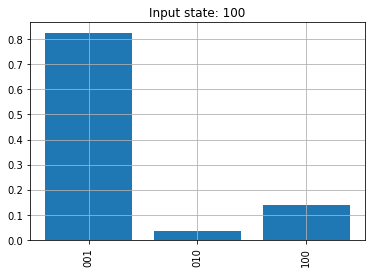

In [17]:
# Probability distribution of sending a photon in the 1st mode 
# through a (3, 3) haar random unitary (3-mode interferometer)
probs_bs1 = BosonSampler.get_theo_prob({"100": 1}, generate_haar_unitary(3))
plot_probs(probs_bs1)

### The post-processing

As we already stated above, the output of the entropy source is not expected to be uniform (e.g: the boson sampling experiment). So, we need to carry a post-processing to obtain a uniform and unbiased random output.

#### The Von Neumann post-processing steps:

Given two samples $s_1$ and $s_2$. We would build our uniform bitstring by:
1. Appending $0$ to our bitstring whenever the i-th element of the sample $s_1$ is greater or equal $1$ and the i-th element of the sample $s_2$ is equal to $0$.
2. Appending $1$ to our bitstring whenever the i-th element of the sample $s_1$ is equal to $1$ and the i-th element of the sample $s_2$ is greater or equal $1$.

#### The theory behind the Von Neumann post-processing: independent elements

Let's assume that we have sample $S$  from an arbitrary (discrete) distribution. The probability that an element of $S$ is equal to 0 is noted $p$. The probability that an element of $S$ is not equal to $0$ is then $1 - p$. Every element from the sample is independent from the others.


We can split that sample $S$ into two samples $V$ and $W$. We know that the samples $V$ and $W$ **should follow the same distribution** as the sample $S$.

##### The probability of appending 0 to the bitstring:

To append $0$ to the bitstring, we should have $V_i \geq 1$ and $W_i = 0$ where the $i$-th subscript indicates the $i$-th element of $V$, $W$ respectively.

$$ P(V_i \geq 1) = 1 - p \quad P(W_i = 0) = p$$


Thus, the probability to append $0$ is:

$$ P(V_i \geq 1 \text{ and } W_i = 0) = (1 - p) \; p$$

##### The probability of appending 1 to the bitstring:

To append $1$ to the bitstring, we should have $V_i = 0$ and $W_i \geq 1$ where the $i$-th subscript indicates the $i$-th element of $V$, $W$ respectively.

$$ P(V_i  = 0) = p \quad P(W_i \geq 0) = 1 - p$$


Thus, the probability to append $1$ is:

$$ P(V_i  = 0 \text{ and } W_i \geq 0) = (1 - p) \; p$$


We can see that the probability that we append $0$ is equal to the probability to append $1$ and thus despite starting with a distribution far from being uniform. We can reach a uniform one.

$$ P(\text{ append } 0) =  P(\text{ append } 1) = (1 - p) \; p$$

##### The probability of discarding the i-th element:
We are also interested in knowing the probability of discarding the $i$-th element as this would impact the rate and cost of our random number generator.

$$ P(\text{ discarding the i-th element }) =  1 - P(\text{ appending } 0) - P(\text{ appending } 1) = 1 - 2p + 2p^2$$

To minimize this probability, We need: $p = 0.5$. As can be checked by looking at the following plot:

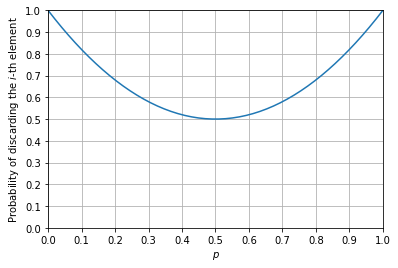

In [18]:
p = np.linspace(0, 1)
plt.plot(p, 1 - 2 * p + 2 * p**2)
plt.grid()
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r"$p$")
plt.ylabel(r"Probability of discarding the $i$-th element")
plt.show()

Knowing this, we can for example try to maximize the efficienty of our random number generator by configuring it (as long as it is possible) to have $p = 0.5$.

For the Qubit-based system, this can be done by applying the hadamard gate on our initial $\ket{0}$ qubit. We would obtain:

$$p = P(0) = P(1) = 0.5$$

And we would be able to harness half of our generated sample to get a random bitstring. 

**Note:** If you have the guarantee that your sample is random and uniform (p = 0.5), you actually don't need to do any post-processing.

If we apply an $R_y$ gate, for example, with angle $\pi / 5$, we would have:

In [19]:
p = np.cos(np.pi / 10)**2

$$p = P(0) = \cos\left(\frac{\pi / 5}{2}\right)^2 \approx 0.90 $$

In [20]:
1 - 2 * p + 2 * p**2

0.8272542485937366

And we would loose 82.7% of our sample, which is a considerable lost.

#### the Von Neumann Post-processing: dependent elements

Let's now assume that the element of our sample $S$ are not independent from one another, in this case the theory becomes more complicated. So, in the interest of time and clarity, let's proceed through examples and observations.

##### Example 01:

Let's assume that we are carrying a boson sampling experiment by sending 2 photons through a 2-mode interferometer.

The possible output that can be detected are: $[1, 1], [2, 0], [0, 2]$ where the first number in the list indicates the number of photons detected in the first detector and the second number indicates the number of photons detected in the second detector.

Let's also assume that the probability to obtain $[1, 1]$ is noted $p_1$, the probability to obtain $[2, 0]$ is $p_2$ and the probability to obtain $[0, 2]$ is $p_3$.

Let's assume that we carried a series of this experiement and obtain a sample of results $S$ and we are interested in the probability to append $0$ and $1$ if we follow the post-processing discussed above.

| $V_i$    | $W_i$    | Probability | Post-processed bitstring |
|----------|----------|-------------|--------------------------|
| $[1, 1]$ | $[1, 1]$ | $p_1^2$     | $[]$                     |
| $[1, 1]$ | $[2, 0]$ | $p_1 p_2$   | $[0]$                    |
| $[1, 1]$ | $[0, 2]$ | $p_1 p_3$   | $[0]$                    |
| $[2, 0]$ | $[1, 1]$ | $p_2 p_1$   | $[1]$                    |
| $[2, 0]$ | $[2, 0]$ | $p_2^2$     | $[]$                     |
| $[2, 0]$ | $[0, 2]$ | $p_2 p_3$   | $[0, 1]$                 |
| $[0, 2]$ | $[1, 1]$ | $p_3 p_1$   | $[1]$                    |
| $[0, 2]$ | $[2, 0]$ | $p_3 p_2$   | $[1, 0]$                 |
| $[0, 2]$ | $[0, 2]$ | $p_3^2$     | $[]$                     |

As we can see, we can append $0$ and $1$ to our bitstring, but we can also append the "words" $01$ or $10$. 

> Word: A predefined substring consisting of a fixed pattern/template (e.g., 010,
0110) ([source](https://nvlpubs.nist.gov/nistpubs/legacy/sp/nistspecialpublication800-22r1a.pdf))

Now, for the bitstring to be truly unbiased the probability of having $0$ or $1$ should be equal BUT ALSO the probability to have $00$, $01$, $10$, $11$ should be equal (and the same applies for longer combinations of 0,1).  An illustration of a bitstring where the $P(0) = P(1)$ but the bitstring is not random is this $01010101$. We can see that $P(0) = P(1)$ but given that we know that the $i$-th is $0$ we are guaranteed that the $i+1$-th bit is 1 and vice versa. A bias might be more suble where given that we know that the $i$-th is a certain value there is unequal probabilities for $i+1$-th bit to be $0$ or $1$.

**Is $P(00) = P(01)$ for the sampling experiment above?**

$$P(0) = p_1 p_2 + p_1 p_3  \qquad P(1) = p_2 p_1 + p_3 p_1$$

So, $$P(0) = P(1)$$. Let's check $P(00)$ and $P(01)$:

00 can be built by assembling the words : `0` `0`, `10` `01`, `0` `01`, `10` `0`.

And the 01 can be built by assemebly the words: `01`, `0` `1`, `10` `1`
<!-- $$P(00) = P(0) \; P(0) \qquad P(01) = P(0) \; P(1) + p_2 p_3$$ -->

In [93]:
def ex1_p_0(p1, p2):
    p3 = 1 - p1 - p2
    p3 = np.where(p3 < 0, np.nan, p3)
    return p1 * p2 + p2 * p3

In [94]:
def ex1_p_1(p1, p2):
    p3 = 1 - p1 - p2
    p3 = np.where(p3 < 0, np.nan, p3)
    return p1 * p2 + p2 * p3

In [100]:
def ex1_p_00(p1, p2):
    p3 = 1 - p1 - p2
    p3 = np.where(p3 < 0, np.nan, p3)
    return ex1_p_0(p1, p2)**2 + 2 * ex1_p_0(p1, p2) * p2 * p3 + p2**2 * p3**2 

In [101]:
def ex1_p_01(p1, p2):
    p3 = 1 - p1 - p2
    p3 = np.where(p3 < 0, np.nan, p3)
    return ex1_p_0(p1, p2) * ex1_p_1(p1, p2) + p2 * p3 + p2 * p3 * ex1_p_1(p1, p2)

In [110]:
def ex1_diff_p00_p01(p1, p2):
    return  ex1_p_00(p1, p2) - ex1_p_01(p1, p2)

In [111]:
p1 = np.linspace(0, 1)
p2 = np.linspace(0, 1)
mp1, mp2 = np.meshgrid(p1, p2)

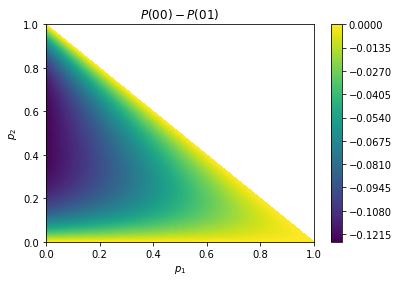

In [112]:
plt.contourf(mp1, mp2, ex1_diff_p00_p01(mp1, mp2), levels=100)
plt.colorbar()
plt.xlabel("$p_1$")
plt.ylabel("$p_2$")
plt.title("$P(00) - P(01)$")
plt.show()

As we can see unless the $p_i$ are fine-tuned, the probabilities of having $00$, $01$ in this example (and in general) are unequal, which would introduce some bias. 

Let's now see what is the probability of not appending anything to our bitstring. 

$$P(\text{not appending}) = p_1^2 + p_2^2 + p_3^2$$

In [28]:
def ex1_p_not_appending(p1, p2):
    p3 = 1 - p1 - p2
    p3 = np.where(p3 < 0, np.nan, p3)
    return p1**2 + p2**2 + p3**2

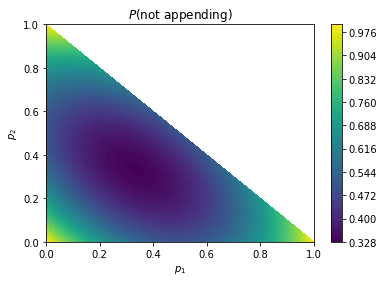

In [29]:
plt.contourf(mp1, mp2, ex1_p_not_appending(mp1, mp2), levels=100)
plt.colorbar()
plt.xlabel("$p_1$")
plt.ylabel("$p_2$")
plt.title("$P($not appending$)$")
plt.show()

We can see that the advantage of having dependent elements in our sample is that we can reach smaller probabilities of not appending anything to our bitstring, which means that we would have less waste and longer bitstrings.

##### Example 02:

Let's try to go a level harder and try to carry a boson sampling experiment like the one describe in section (3.2) of [Shi et al.](#References).

In this experiment, we are sending two photons into a 5-mode interferometer and collecting the results. We implemented a boson sampling simulator which we can use to to carry this experiment and study the output.

In [30]:
probs_ex2 = BosonSampler.get_theo_prob(shi_input_dict_fig4, shi_unitary5)

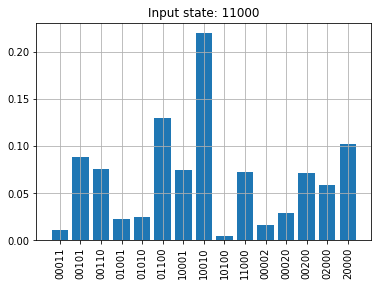

In [31]:
plot_probs(probs_ex2)

As you can see, we retrieve the same probability distribution as in figure 4. (a). Now, let's see what we would obtain when we draw random samples from this distribution and postprocess them:

In [32]:
study_boson_sampler(probs_ex2)

{'': 0.44304139369062234,
 '01': 0.6249299343169981,
 '0011': 0.05689875094630071,
 '1': 0.345105289406096,
 '011': 0.18773149775052814,
 '10': 0.6249299343169981,
 '0101': 0.10730937865653906,
 '101': 0.1890817329403677,
 '0110': 0.1898526313346462,
 '110': 0.07755980340426805,
 '1001': 0.1898526313346462,
 '1010': 0.10730937865653906,
 '1100': 0.05689875094630071,
 '0': 0.3451052894060961,
 '001': 0.07755980340426803,
 '010': 0.1890817329403677,
 '100': 0.18773149775052814}

The function `study_boson_sampler` takes the output of `BosonSampler.get_theo_prob` and output a dictionnary whose keys are "words" and the values are the probabilities that these "words" gets appended to our final bitstring. 

As we can see the probability that nothing gets appended to the bitstring is very low 11% compared the minimal 50% for independent elements case. 

But, as we saw in the previous example, this comes at price which is that in the general case unless we choose our unitary very carefully there would be a small bias in our final bitstring as the probability of to have certain words in our bitstring is higher to the probability of having other words.

##### Example 03:

Let's look at another example in which the bias is more clear. Let's pick a 10-mode interferometer and send either one photon in each of the 5th and 6th mode or one photon in each of the 4th and 7th mode with probability 50% for each (look at the `ex3_input` below).

In [33]:
from scipy.linalg import block_diag
ex3_input = {"0000110000": 0.5, "0001001000": 0.5}
ex3_unitary = block_diag(generate_haar_unitary(5), shi_unitary5)

In [34]:
probs_ex3 = BosonSampler.get_theo_prob(ex3_input, ex3_unitary)

In [35]:
study_boson_sampler(probs_ex3)

{'': 0.06971700961878208,
 '01': 0.19539514484448495,
 '0101': 0.13487413247397828,
 '10': 0.1953951448444849,
 '0110': 0.1348741324739783,
 '1001': 0.13487413247397828,
 '1010': 0.13487413247397825}

As you can see here, the bias in the bitstring would be more obvious in this case. Given a bitstring generated with such an input and unitary. If we have $00$, we are certain that the next bit would be a $1$ and vice versa (if you are unsure why this is the case, try to pick any random two "words" from the results above and try to construct a bitstring with 3 consecutive $0$ or $1$, it is impossible!!!)

#### Post-processing: dependent elements, the unbiased way

As we just saw, if we have a sample whose elements are dependent, we can generate bitstrings with less losses but at the cost of introducing suble (or less suble) biases. 

In what follows, we propose a post-processing schema to generate an unbiased bitstring from a sample with dependent elements.

First lets. observe that in the example 2 and example 3, the probabilities to append a word which starts with a $0$ is similar to the probability of appending a word which starts with a $0$. (for example (2): the probabilities are ~ 44.46% and for example (3): the probabilities are 47%)


1. We pass the sample through the Von Neumann post-processing.
2. Instead of appending the words produced in the previous step to the bitstring, we append a $0$ to the bitstring if the word starts with $0$ and $1$ if the word starts with a $1$. 

#### Conclusion:

We found two methods to postprocess the random output of the entropy source. Both the methods are similar for samples with independent elements but for samples with dependent element the Von Neumann method offers a higher rate but (in general) introduces some biasness. The [CQT method](#Post-processing:-dependent-elements,-the-unbiased-way) offers an unbiased output but at a slower rate.


## Testing the randomness

<img src="https://i.imgur.com/dmhKrL3.jpg" style="height: 200px" />

Now, that we have methods to generate random numbers. We need a test to measure how random they are. As we saw in the previous sections, looking for the frequencies of $0$s and $1$s (entropy) is not enough. We should also look for repeating words, patterns, and etc. In what follows, we will assess the randomness of our bitstring by the using the [nistrng package](https://pypi.org/project/nistrng/), which is a python package implementing the 15 tests of the [NIST SP 800-22](https://nvlpubs.nist.gov/nistpubs/legacy/sp/nistspecialpublication800-22r1a.pdf) test-suite. A pedagogical review of some the tests can be found [here](https://medium.com/unitychain/provable-randomness-how-to-test-rngs-55ac6726c5a3). 

For the interpretation of the NIST results, we will refer to the [this paper](https://www.researchgate.net/publication/287224641_On_the_interpretation_of_results_from_the_NIST_statistical_test_suite). 

Beside that, we will also plot the distribution of the different BITs, BYTEs (8-bits) and possibly WORDs (16-bits), and DWORDs (32-bits) so that reader can have an simple visual representation of how unbiased (or biased) the outputs are.

For example, lets generate a very biased bitstring `a` and a less biased one `b`.

In [36]:
a = np.tile([0, 1, 1, 0, 1], 30_000)
print(a[:20])

[0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1]


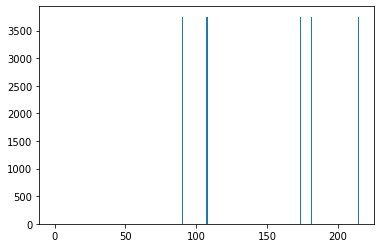

In [37]:
draw_distribution(a)

In [38]:
b = np.random.randint(0, 2, size = 100_000)
print(b[:20])

[1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1]


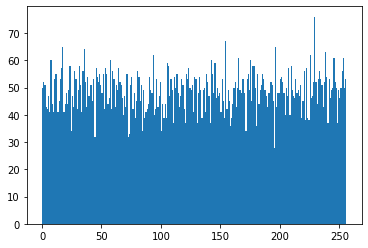

In [39]:
draw_distribution(b)

As you can the `a` bitstring is just the word `01101` repeated. When we construct a bytestring of it, we observe that the distribution of bytes is far from uniform.

On the hand, the `b` bitstring is the output of `numpy`'s rng. And we observe that the bytes are more uniformly distributed.

We can quantify the distribution of bytes by using the same method as for the distribution of bits (by using the entropy).

In [40]:
calculate_entropy(a, type = "bytes")

0.29024101186092033

In [41]:
calculate_entropy(b, type = "bytes")

0.9980966409119127

## The CQT RNG package

<img src="https://i.ibb.co/p1r35Zr/CQT-RNG-3.jpg" />

We gathered all the necessary code to generate a random bitstring and developped a package that was designed to be simple and extendable. The core of the package are three classes. The `RNG`, `EntropySource`, and `PostProcessor` classes. 

The `RNG` classes takes an entropy source and a postprocessor. The entropy source should be a subclass of the `EntropySource` abstract class and the postprocessor should be a subclass of the `PostProcessor` abstract class. 

This leaves plenty of room for the end-user to add his own entropy sources and post processors.

We also provide some entropy sources:
* `UniversalQCSampler`: Based on the [Qubit approach](#Quantum-RNG:-Qubits), simulated on qiskit's [aer_simulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.AerSimulator.html).
* `ShiSFSampler`: Based on the approach described in [Shi et al.](https://arxiv.org/pdf/2206.02292.pdf), simulated on Strawberry Fields' [fock backend](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.FockBackend.html).
* `BosonSampler`: Simulates a boson sampling experiment. Default arguments simulate the Shi et al. circuit. Faster than the Strawberry fields simulator.
* `IBMQSampler`: Based on the [Qubit approach](#Quantum-RNG:-Qubits), experiment carried on [IBMQ hardware](https://www.ibm.com/quantum).
* `BorealisSampler`: Based on Gaussian Boson Sampling, experiments carried on [Xanadu hardware](https://cloud.xanadu.ai/).
* `Loader`: An entropy source which delivers samples from data inputted as `np.array`.

We also provide three postprocessors:
* `VonNeumannPP`: Based on the [Von Neumann postprocessing](#The-Von-Neumann-post-processing-steps:)
* `CQTPP`: Based on the approach described [here](#Post-processing:-dependent-elements,-the-unbiased-way)
* `NoPostProcess`: Doesn't carry any postprocessing. Just appends the two samples.

_For more example, please refer to the [documentation]()._

### Qubits-based Simulator

To generate a bitstring of length 100 using the [Qubit-based approach](#Quantum-RNG:-Qubits) as an entropy source and the [Von Neumann postprocessor](#The-Von-Neumann-post-processing-steps:):

In [119]:
from cqt_rng import RNG
from cqt_rng.entropy_sources import UniversalQCSampler
from cqt_rng.post_processors import VonNeumannPP

In [120]:
es1 = UniversalQCSampler(nb_qubits = 5)
rng1 = RNG(entropy_source=es1, postprocessor=VonNeumannPP())

In [121]:
bs1 = rng1.generate(100_000)

100001it [00:00, 128076.83it/s]                                                 


Fairly easy isn't it? Let's pass the output through some tests

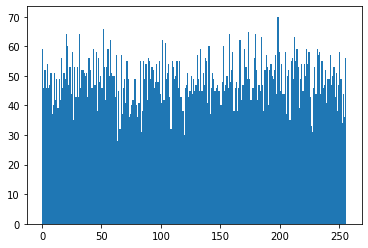

In [122]:
draw_distribution(bs1)

In [123]:
calculate_entropy(bs1, type = "bits")

0.9999990293545589

In [124]:
calculate_entropy(bs1, type="bytes")

0.99789714115691

In [125]:
nist_tests(bs1)

Eligible test from NIST-SP800-22r1a:
-monobit
-frequency_within_block
-runs
-longest_run_ones_in_a_block
-binary_matrix_rank
-dft
-non_overlapping_template_matching
-serial
-approximate_entropy
-cumulative sums
Test results:
- PASSED - score: 0.714 - Monobit - elapsed time: 0 ms
- PASSED - score: 0.553 - Frequency Within Block - elapsed time: 12 ms
- PASSED - score: 0.742 - Runs - elapsed time: 30 ms
- PASSED - score: 0.442 - Longest Run Ones In A Block - elapsed time: 12 ms
- PASSED - score: 0.512 - Binary Matrix Rank - elapsed time: 621 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 5 ms
- FAILED - score: 0.0 - Non Overlapping Template Matching - elapsed time: 338 ms
- FAILED - score: 0.0 - Serial - elapsed time: 3542 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 5340 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 106 ms
Total failed tests: 5/10


Now, let's try to check the point we made in [here](#The-probability-of-discarding-the-i-th-element:)

In [126]:
es2 = UniversalQCSampler(nb_qubits = 5, operation="hadamard")

In [127]:
sample2 = es2.sample(100_000)

In [128]:
a = sample2[:50_000]
b = sample2[50_000:]

In [129]:
len(VonNeumannPP().postprocess(a, b))

24945

We can see that after postprocessing, we lost ~50% of sample `a`'s size. We went from 50k to 25k. As predicted in the theoretical part. Now, let's try a rotation with angle $\pi / 5$.

In [130]:
es3 = UniversalQCSampler(nb_qubits = 5, operation = "rotation", angle = np.pi / 5)

In [131]:
sample3 = es3.sample(100_000)

In [132]:
a = sample3[:50_000]
b = sample3[50_000:]

In [133]:
len3 = len(VonNeumannPP().postprocess(a, b))
print(len3)

8550


In [134]:
np.round(100 * (50_000 - len3) / 50_000, 2)

82.9

Which means that we lost ~ 82% in the post-process as predicted above.

### Shi et al. Simulator(s)

In the Shi et al. paper, we send two photons through one of two 5-mode interferometer arbitrarily. The experiment can be simulater either with the `ShiSFSampler` which uses Strawberry Fields or the `BosonSampler` which uses a custom simulator and is way faster than strawberry fields. 

Let's try both:

#### Strawberry Fields:

In [56]:
from cqt_rng.entropy_sources import ShiSFSampler

In [57]:
rng2 = RNG(ShiSFSampler(), VonNeumannPP())

In [58]:
bs2 = rng2.generate(100)

103it [20:12, 11.78s/it]                                                        


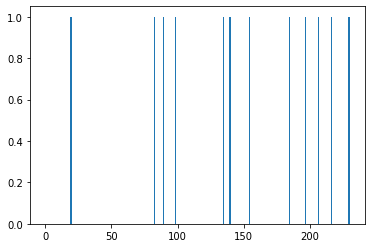

In [59]:
draw_distribution(bs2)

In [ ]:
calculate_entropy(bs2, type="bits")

In [ ]:
calculate_entropy(bs2, type="bytes")

The distribution is highly non-uniform because the bitstring is very small (100 bits).

In [60]:
nist_tests(bs2)

Eligible test from NIST-SP800-22r1a:
-monobit
-frequency_within_block
-runs
-non_overlapping_template_matching
-serial
-approximate_entropy
-cumulative sums
Test results:
- PASSED - score: 0.549 - Monobit - elapsed time: 0 ms
- PASSED - score: 0.963 - Frequency Within Block - elapsed time: 0 ms
- PASSED - score: 0.298 - Runs - elapsed time: 0 ms
- PASSED - score: 0.86 - Non Overlapping Template Matching - elapsed time: 1 ms
- PASSED - score: 0.324 - Serial - elapsed time: 6 ms
- PASSED - score: 0.105 - Approximate Entropy - elapsed time: 6 ms
- PASSED - score: 0.722 - Cumulative Sums - elapsed time: 0 ms
Total failed tests: 0/7


#### Custom simulator:

Let's try to carry a similar experiment on our custom simulator. And let's try to confirm that the Shi et al. method (which uses the Von Neumann Post Processing) should give longer but more biased bitstrings compared to the post processing method proposed in  [here](#Post-processing:-dependent-elements,-the-unbiased-way)

In [135]:
from cqt_rng.entropy_sources import BosonSampler
from cqt_rng.post_processors import CQTPP

In [136]:
sample = BosonSampler().sample(5_000_000)

In [137]:
a = sample[:2_500_000]
b = sample[2_500_000:]

In [138]:
bs_vpp = VonNeumannPP().postprocess(a, b)

In [139]:
len(bs_vpp)

659846

In [140]:
bs_cqtpp = CQTPP(dep_seq_len = 10).postprocess(a, b)

In [141]:
len(bs_cqtpp)

233595

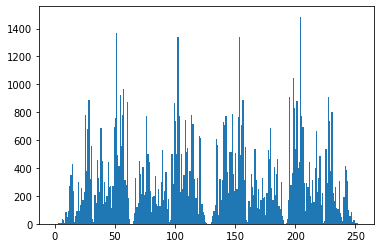

In [142]:
draw_distribution(bs_vpp)

In [143]:
calculate_entropy(bs_vpp, type = "bits")

0.9999999013631877

In [144]:
calculate_entropy(bs_vpp, type = "bytes")

0.9299831469725385

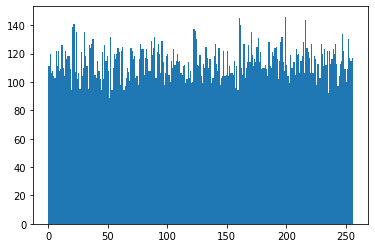

In [145]:
draw_distribution(bs_cqtpp)

In [146]:
calculate_entropy(bs_cqtpp, type = "bits")

0.9999926627935408

In [147]:
calculate_entropy(bs_cqtpp, type = "bytes")

0.9992100665162176

In [70]:
nist_tests(bs_vpp)

Eligible test from NIST-SP800-22r1a:
-monobit
-frequency_within_block
-runs
-longest_run_ones_in_a_block
-binary_matrix_rank
-dft
-non_overlapping_template_matching
-maurers_universal
-serial
-approximate_entropy
-cumulative sums
Test results:
- PASSED - score: 0.88 - Monobit - elapsed time: 0 ms
- PASSED - score: 1.0 - Frequency Within Block - elapsed time: 1 ms
- FAILED - score: 0.0 - Runs - elapsed time: 158 ms
- FAILED - score: 0.0 - Longest Run Ones In A Block - elapsed time: 10 ms
- PASSED - score: 0.831 - Binary Matrix Rank - elapsed time: 3667 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 322 ms
- FAILED - score: 0.0 - Non Overlapping Template Matching - elapsed time: 1938 ms
- PASSED - score: 0.02 - Maurers Universal - elapsed time: 1255 ms
- FAILED - score: 0.0 - Serial - elapsed time: 24627 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 36635 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 625 ms
Total failed tests: 7/11


In [71]:
nist_tests(bs_cqtpp)

Eligible test from NIST-SP800-22r1a:
-monobit
-frequency_within_block
-runs
-longest_run_ones_in_a_block
-binary_matrix_rank
-dft
-non_overlapping_template_matching
-serial
-approximate_entropy
-cumulative sums
Test results:
- PASSED - score: 0.843 - Monobit - elapsed time: 0 ms
- PASSED - score: 0.22 - Frequency Within Block - elapsed time: 3 ms
- PASSED - score: 0.914 - Runs - elapsed time: 100 ms
- PASSED - score: 0.629 - Longest Run Ones In A Block - elapsed time: 11 ms
- PASSED - score: 0.062 - Binary Matrix Rank - elapsed time: 1346 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 89 ms
- PASSED - score: 0.115 - Non Overlapping Template Matching - elapsed time: 772 ms
- FAILED - score: 0.0 - Serial - elapsed time: 8617 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 12287 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 206 ms
Total failed tests: 4/10


As you can see the length of the bitstring generated by the Von Neumann method is longer but the CQTPP is more uniform.

### Real Devices: IBMQ

Let's now try to apply generate random numbers using a real quantum device. Let's start with the IBMQ device which is based on Qubits.

In [72]:
from cqt_rng.entropy_sources import IBMQSampler
# rng3  = RNG(IBMQSampler(), VonNeumannPP())
# rng3.generate(1000)

To avoid consuming your IBMQ plan and for the sake of example, we provided a sample of IBMQ data that we already collected.

In [148]:
from cqt_rng.entropy_sources import Loader
from cqt_rng.post_processors import NoPostProcess

In [149]:
# downloading the data

available_data = glob.glob("data/*")
file = "hadamards.ibmq.npy"
data_url = "https://raw.githubusercontent.com/CQTech-womanium-hackathon/Random-number-generation-using-boson-sampling---ORCA-Computing/main/challenge/data/hadamards.ibmq.npy"

if os.path.join("data", file) not in available_data:
        print("Downloading the data:", file)
        d = requests.get(data_url)
        open(os.path.join("data", file), "wb").write(d.content)

In [150]:
# raw data
data_ibmq_str = np.load("data/hadamards.ibmq.npy")
print(data_ibmq_str[:4])

['10100' '00101' '01000' '00100']


In [151]:
# let's transform it to a 0-1 bitstring.
data_ibmq = np.zeros(len(data_ibmq_str) * 5, dtype=np.int8)
for i in range(len(data_ibmq_str)):
    for j in range(5):
        data_ibmq[i * 5 + j] = int(data_ibmq_str[i][j])

In [152]:
print(data_ibmq[:20])

[1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0]


In [153]:
es_ibmq = Loader(data = data_ibmq, seq_len = 5)

In [154]:
 # We know that a hadamard circuit guarantees 50%/50% output, no need to postprocess :).
rng3 = RNG(es_ibmq, NoPostProcess())

In [155]:
bs3 = rng3.generate(5000)

5002it [00:00, 1467126.48it/s]                                                  


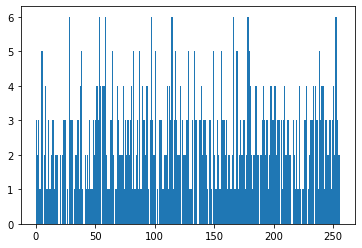

In [156]:
draw_distribution(bs3)

In [157]:
calculate_entropy(bs3, type = "bits")

0.99999434462805

In [158]:
calculate_entropy(bs3, type = "bytes")

0.9609801103887046

In [159]:
nist_tests(bs3)

Eligible test from NIST-SP800-22r1a:
-monobit
-frequency_within_block
-runs
-longest_run_ones_in_a_block
-dft
-non_overlapping_template_matching
-serial
-approximate_entropy
-cumulative sums
Test results:
- PASSED - score: 0.843 - Monobit - elapsed time: 0 ms
- PASSED - score: 0.194 - Frequency Within Block - elapsed time: 1 ms
- PASSED - score: 0.843 - Runs - elapsed time: 7 ms
- PASSED - score: 0.198 - Longest Run Ones In A Block - elapsed time: 0 ms
- PASSED - score: 0.436 - Discrete Fourier Transform - elapsed time: 1 ms
- PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 14 ms
- PASSED - score: 0.535 - Serial - elapsed time: 190 ms
- PASSED - score: 0.85 - Approximate Entropy - elapsed time: 271 ms
- PASSED - score: 0.679 - Cumulative Sums - elapsed time: 6 ms
Total failed tests: 0/9


We can see from the plot (despite the fact that we are generating a small bitstring) and from the tests results that we are getting really good results.

### Real Devices: Borealis

As with IBMQ, we can carry the experiment directly on Xanadu's Borealis:

In [83]:
from cqt_rng.entropy_sources import BorealisSampler
# rng4  = RNG(BorealisSampler(), VonNeumannPP())
# rng4.generate(1000)

As for the IBMQ section, we will avoid consuming your free (or paid) plan. And we will use the [data published by Xanadu](https://github.com/XanaduAI/xanadu-qca-data):

In [160]:
# downloading the data

available_data = glob.glob("data/*")
file = "borealis.npy"
data_url = "https://qca-data.s3.amazonaws.com/fig4/samples.npy"

if os.path.join("data", file) not in available_data:
        print("Downloading the data:", file)
        d = requests.get(data_url)
        open(os.path.join("data", file), "wb").write(d.content)

In [161]:
data_borealis = np.load("data/borealis.npy")

In [162]:
data_borealis

array([[[1, 0, 0, ..., 1, 0, 0]],

       [[2, 0, 0, ..., 0, 0, 1]],

       [[2, 0, 0, ..., 1, 0, 0]],

       ...,

       [[1, 4, 1, ..., 1, 0, 3]],

       [[0, 0, 0, ..., 1, 0, 0]],

       [[0, 2, 1, ..., 1, 0, 0]]], dtype=int8)

In [87]:
data_borealis = np.ravel(data_borealis)

In [88]:
es_borealis = Loader(data = data_borealis, seq_len = 216, dep_seq_len = 216)

In [89]:
rng4 = RNG(es_borealis, CQTPP(dep_seq_len = 216))

In [90]:
bs4 = rng4.generate(500_000)

100%|████████████████████████████████| 500000/500000 [00:26<00:00, 19226.02it/s]


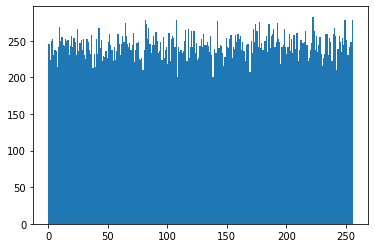

In [91]:
draw_distribution(bs4)

In [ ]:
calculate_entropy(bs4, type = "bits")

In [ ]:
calculate_entropy(bs4, type = "bytes")

In [92]:
nist_tests(bs4)

Eligible test from NIST-SP800-22r1a:
-monobit
-frequency_within_block
-runs
-longest_run_ones_in_a_block
-binary_matrix_rank
-dft
-non_overlapping_template_matching
-maurers_universal
-serial
-approximate_entropy
-cumulative sums
Test results:
- PASSED - score: 0.686 - Monobit - elapsed time: 0 ms
- PASSED - score: 0.525 - Frequency Within Block - elapsed time: 1 ms
- PASSED - score: 0.827 - Runs - elapsed time: 129 ms
- PASSED - score: 0.77 - Longest Run Ones In A Block - elapsed time: 11 ms
- PASSED - score: 0.194 - Binary Matrix Rank - elapsed time: 3178 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 37 ms
- FAILED - score: 0.0 - Non Overlapping Template Matching - elapsed time: 1256 ms
- PASSED - score: 0.019 - Maurers Universal - elapsed time: 956 ms
- FAILED - score: 0.0 - Serial - elapsed time: 17650 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 26486 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 474 ms
Total failed tests: 5/1

## Conclusion

In this notebook, we showed the importance of RNGs and the theory behind them, and how to build one. We also mentionned two methods to post-process entropy sources output depending if you value rate (Von Neumann) over biasness (CQTPP). Then, we presented a tool that we developped to generate random numbers. The tool was developped to be **simple and extendible to fit users' needs  and resources**. Finally, we passed the results that tool provides (for IBMQ and Borealis) through a battery of tests. We saw that the bitstrings that are generated are **evenly distributed and that they get decent NIST scores**.

## References

1. [An Unbiased Quantum Random Number Generator Based
on Boson Sampling](https://arxiv.org/pdf/2206.02292.pdf)
1. [NIST SP 800-22](https://nvlpubs.nist.gov/nistpubs/legacy/sp/nistspecialpublication800-22r1a.pdf)
1. [Provable Randomness: How to Test RNGs](https://medium.com/unitychain/provable-randomness-how-to-test-rngs-55ac6726c5a3)
1. [On the interpretation of results from the NIST statistical test suite](https://www.researchgate.net/publication/287224641_On_the_interpretation_of_results_from_the_NIST_statistical_test_suite)
1. [Quantum computational advantage with a programmable photonic processor](https://www.nature.com/articles/s41586-022-04725-x)
1. [Where does python get its random numbers from?](https://towardsdatascience.com/where-does-python-get-its-random-numbers-from-81dece23b712)